In [2]:
using Gen
using Plots
include("softmax.jl");

In [34]:
# let's choose a nonlinearity σ
σ(x) = tanh.(x);

σ(x) = 1.7159 * tanh.(x * 0.66666);

In [4]:
# Let's define our two layer neural network model
# We will use Gen's differentiable programming capabilities.
# For full-powers neural net modeling + probabilistic programming, 
#   consider using GenFlux https://github.com/probcomp/GenFlux.jl
@gen function neural_net_model(input, output)
    # uses @params to define the parameters 
    # that will go into our neural net model
    @param W1::Matrix{Float64}
    @param W2::Matrix{Float64}

    # the non-linear features
    hidden_layer_1 = σ(W1 * input)
    # classification layer via a linear layer
    h_θ  = W2 * hidden_layer_1

    # draw a category label from the softmax distribution
    # gen attempts to maximize the log of this, which is in effect 
    # the cross-entropy loss (due to the equivalence b/w MLE and CE)
    class_label ~ categorical(softmax(h_θ))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##neural_net_model#292", Bool[0, 0], false)

In [5]:
# Let's define our two layer neural network model
# We will use Gen's differentiable programming capabilities.
# For full-powers neural net modeling + probabilistic programming, 
#   consider using GenFlux https://github.com/probcomp/GenFlux.jl
@gen function neural_net_model(input, output)
    # uses @params to define the parameters 
    # that will go into our neural net model
    @param W1::Matrix{Float64}
    @param b1::Vector{Float64}
    @param W2::Matrix{Float64}
    @param b2::Vector{Float64}

    # the non-linear features
    hidden_layer_1 = σ(W1 * input .+ b1)
    # classification layer via a linear layer
    h_θ  = W2 * hidden_layer_1 .+ b2

    # draw a category label from the softmax distribution
    # gen attempts to maximize the log of this, which is in effect 
    # the cross-entropy loss (due to the equivalence b/w MLE and CE)
    class_label ~ categorical(softmax(h_θ))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##neural_net_model#293", Bool[0, 0], false)

In [6]:
# get an optimizer
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), neural_net_model);

# initialize the params, implement a data loader
# ...
# train
Gen.train!(neural_net_model, data_generator, update,
    num_epoch=50, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);

LoadError: UndefVarError: `data_generator` not defined

Linear regression with data-driven proposals

In [9]:
@gen function model(xs::Vector{Float64})
    slope = @trace(normal(-1, exp(0.5)), :slope)
    intercept = @trace(normal(1, exp(2.0)), :intercept)
    for (i, x) in enumerate(xs)
        {:y=>i} ~ normal(slope * x + intercept, 1)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##model#296", Bool[0], false)

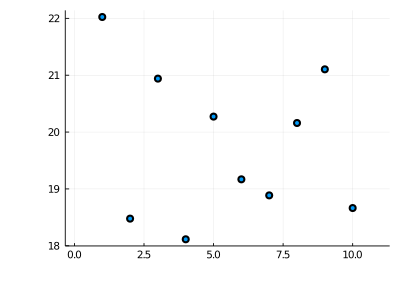

In [170]:
xs = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
tr = Gen.simulate(model, (xs, ))
get_choices(tr)
observations_sim = Gen.choicemap()
[observations_sim[:y=>i] = tr[:y=>i] for i in 1:length(xs)]
ys = []
[push!(ys, observations_sim[:y=>i]) for i in 1:length(xs)]
scatter(xs, ys, xlims=[0, 11], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

In [149]:
@gen function neural_amortized_inference(ys::Vector{Float64})
    
    # uses @params to define neural net weights
    @param W1::Matrix{Float64}
    @param b1::Vector{Float64}
    @param W2::Matrix{Float64}
    @param b2::Vector{Float64}

    # non-linear hidden layer
    hidden_layer_1 = σ(W1 * ys .+ b1)
    # output layer
    h_θ  = W2 * hidden_layer_1 .+ b2

    # collect the variational approximation parameters
    slope_mu = h_θ[1]
    slope_log_std = h_θ[2]
    intercept_mu = h_θ[3]
    intercept_log_std = h_θ[4];
    
    # make the relevant random choices with these parameters
    slope ~ normal(slope_mu, exp(slope_log_std))
    intercept ~ normal(intercept_mu, exp(intercept_log_std))

    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##data_driven_proposal_net#320", Bool[0], false)

In [150]:
# use the generative model to generate synthetic data
function data_generator()
    xs = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

    # simulate data using the prior 
    tr = Gen.simulate(model, (xs, ))
    get_choices(tr)
    
    # record the "observations" (inputs to the NN model)
    ys = []
    [push!(ys, tr[:y=>i]) for i in 1:length(xs)]
    ys = convert(Vector{Float64}, ys)
    
    # record the random choices (outputs of the NN model)
    choices = Gen.choicemap()
    choices[:slope] = tr[:slope]
    choices[:intercept] = tr[:intercept]
    return ((ys,), choices)
end

data_generator (generic function with 2 methods)

In [162]:
# choose the number of units each layer of the network
num_units_hidden_layer = 50

# a function for randomly initializing the weight matrices
init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

# get values to initialize W1 and W2
init_W1 = init_weight(num_units_hidden_layer, 10)
init_W2 = init_weight(4, num_units_hidden_layer)

# now initialize the params of the data-driven proposal function
init_param!(neural_amortized_inference, :W1, init_W1)
init_param!(neural_amortized_inference, :b1, zeros(num_units_hidden_layer))
init_param!(neural_amortized_inference, :W2, init_W2)
init_param!(neural_amortized_inference, :b2, zeros(4))

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [186]:
# get a gradient-based optimizer and train!
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(1e-7), neural_amortized_inference);
scores = Gen.train!(neural_amortized_inference, data_generator, update,
    num_epoch=100, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: -3.4685198797599437
epoch 2: generating 100 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: -3.352731201893688
epoch 3: generating 100 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: -3.7802503081571355
epoch 4: generating 100 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: -3.3513620322027795
epoch 5: generating 100 training examples...
epoch 5: training using 100 minibatches of size 100...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: -3.385012648569645
epoch 6: generating 100 training examples...
epoch 6

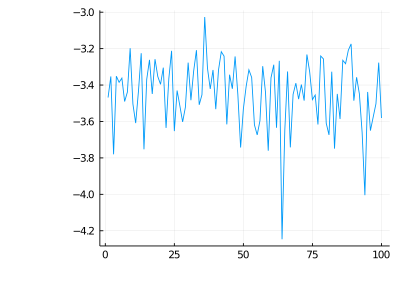

In [187]:
plot(scores, thickness_scaling=3.5, size=(1600, 1200), legend=:none)

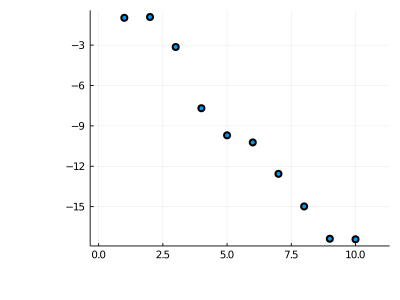

In [222]:
xs = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
tr = Gen.simulate(model, (xs, ))
get_choices(tr)
ys = []
[push!(ys, tr[:y=>i]) for i in 1:length(xs)]
ys = convert(Vector{Float64}, ys)
scatter(xs, ys, xlims=[0, 11], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

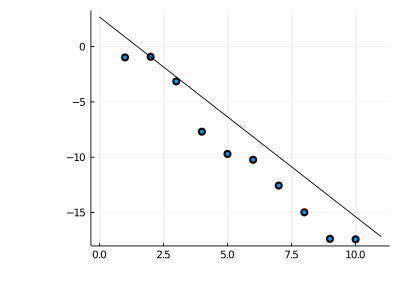

In [225]:
#traces = []
#for i=1:100
#    tr, _ = Gen.generate(neural_amortized_inference, (ys,))
#    push!(traces, tr)
#end
#visualize_trace(traces, xs, ys, "Data-driven Proposal")

tr, _ = Gen.generate(neural_amortized_inference, (ys,))
get_choices(tr)
visualize_trace(tr, xs, ys, "DD proposal")

In [210]:
function visualize_trace(trs, xs, ys, title)
    if typeof(trs)==Vector{Any}
        tr = trs[1]
        N = length(trs)
    else
        tr = trs
        N = 1
    end
    plt = scatter(xs, ys, xlims=[0, 11], label=nothing, thickness_scaling=3.5, size=(1600, 1200))
    for i = 1:N
        if i == 1
            tr = tr
        else
            tr = trs[i]
        end
        left_x = 0
        left_y  = tr[:slope] * left_x + tr[:intercept]
        right_x = 11
        right_y = tr[:slope] * right_x + tr[:intercept]
        plt = plot!([left_x, right_x], [left_y, right_y], color="black", label=nothing) 
    end
    plt
end

visualize_trace (generic function with 1 method)

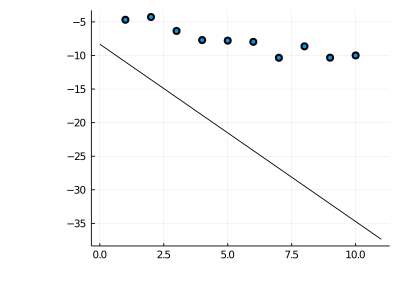